In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sundarannamalai_hair_diseases_path = kagglehub.dataset_download('sundarannamalai/hair-diseases')

print('Data source import complete.')


#Import

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

# Define path

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = r'../input/hair-diseases/Hair Diseases - Final/train'
test_path = r'../input/hair-diseases/Hair Diseases - Final/test'
val_path = r'../input/hair-diseases/Hair Diseases - Final/val'

# Create model


In [ ]:
#Load Pretrained MobileNetV2 Model
mobileNetV2 = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#Freezes all MobileNetV2 layers so their weights are not updated during training.
for layer in mobileNetV2.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Get the number of classes from the training directory
folders = glob(train_path + '/*')
num_classes = len(folders)
# Build custom classifier on top of MobileNetV2
x = Flatten()(mobileNetV2.output)
prediction = Dense(num_classes, activation='softmax')(x)
# Create model
model = Model(inputs=mobileNetV2.input, outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Load data

In [ ]:
# ImageDataGenerator is used to load, preprocess, and augment images.  scales pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
# Load images from folders
train_set = train_datagen.flow_from_directory(directory=train_path,
                                                target_size = (224,224),
                                                batch_size = 64,
                                                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical', shuffle=False)
val_set = val_datagen.flow_from_directory(directory=val_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical', shuffle=False)

Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


# Compile model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model

In [ ]:
history = model.fit(
                  train_set,
                  validation_data=val_set,
                  epochs=20,
                  batch_size=128,
                  steps_per_epoch=len(train_set),
                  validation_steps=len(test_set)
                )

Epoch 1/20
150/150 [==============================] - 267s 2s/step - loss: 2.5269 - accuracy: 0.7731 - val_loss: 0.2511 - val_accuracy: 0.9475
Epoch 2/20
150/150 [==============================] - 159s 1s/step - loss: 0.5480 - accuracy: 0.9120 - val_loss: 0.3233 - val_accuracy: 0.9508
Epoch 3/20
150/150 [==============================] - 157s 1s/step - loss: 0.3809 - accuracy: 0.9418 - val_loss: 0.2713 - val_accuracy: 0.9608
Epoch 4/20
150/150 [==============================] - 157s 1s/step - loss: 0.3468 - accuracy: 0.9523 - val_loss: 0.1849 - val_accuracy: 0.9758
Epoch 5/20
150/150 [==============================] - 156s 1s/step - loss: 0.3660 - accuracy: 0.9529 - val_loss: 0.1600 - val_accuracy: 0.9808
Epoch 6/20
150/150 [==============================] - 157s 1s/step - loss: 0.2639 - accuracy: 0.9655 - val_loss: 0.1827 - val_accuracy: 0.9767
Epoch 7/20
150/150 [==============================] - 161s 1s/step - loss: 0.2780 - accuracy: 0.9666 - val_loss: 0.1380 - val_accuracy: 0.9783

# Save model

In [ ]:
model.save("MobileNetV2-Final.h5")
print("Model Saved as : MobileNetV2-Final.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved as : MobileNetV2-Final.h5


# Evaluate

In [ ]:
evl = model.evaluate(test_set)

test_loss, test_acc = evl[0]*100, evl[1]*100


print(f'Test Accuracy = {test_acc} %')
print(f'Test Loss = {test_loss} %')

19/19 [==============================] - 16s 884ms/step - loss: 0.1261 - accuracy: 0.9933
Test Accuracy = 99.33333396911621 %
Test Loss = 12.605080008506775 %


#Plot

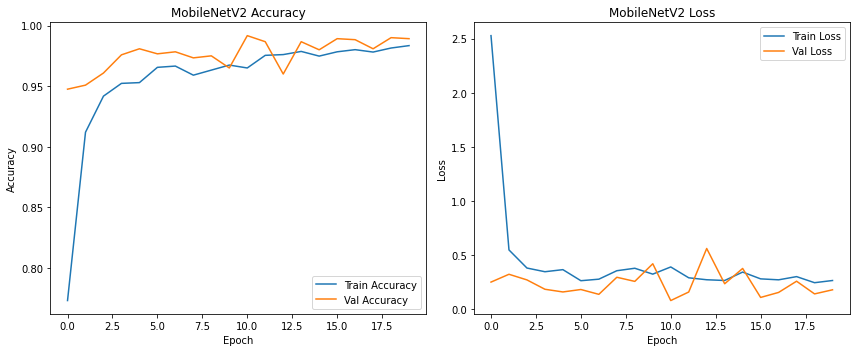

In [ ]:

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


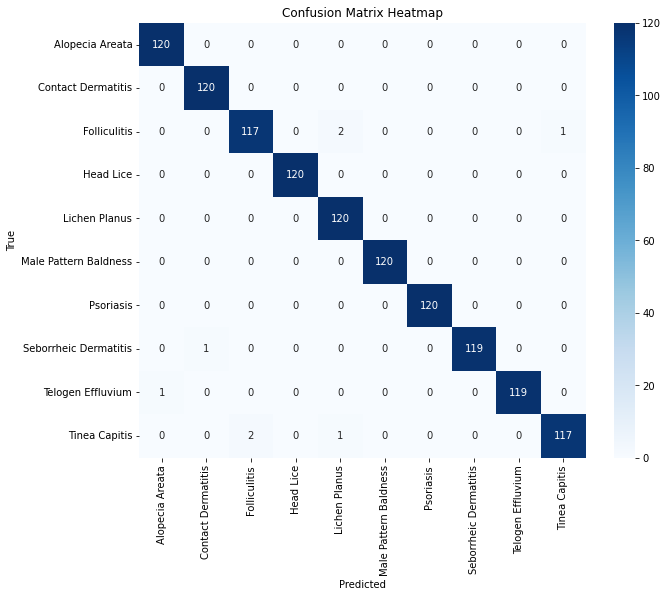

In [ ]:

# Get true labels and predicted labels
true_labels = test_set.classes
pred_probs = model.predict(test_set)
pred_labels = np.argmax(pred_probs, axis=1)

# Class names
class_names = list(test_set.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


Found 1200 images belonging to 10 classes.


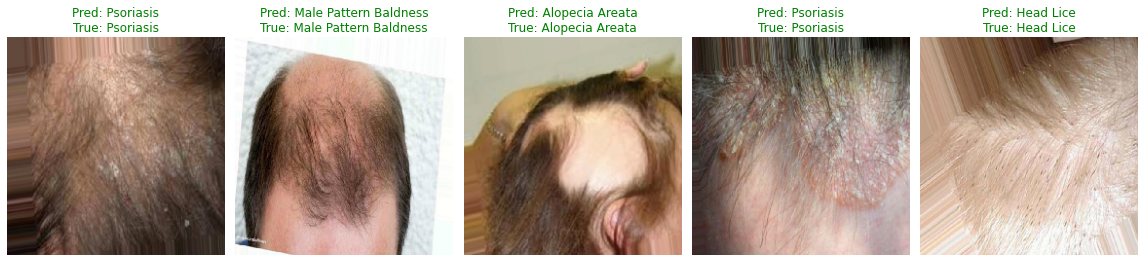

In [ ]:

# Get test images and true labels
x_test, y_true = next(test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1000,
    class_mode='categorical',
    shuffle=False))

# Predict with the model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Choose random indices to visualize
n = 5
indices = random.sample(range(len(x_test)), n)

# Plot images with predictions
plt.figure(figsize=(16, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, n, i + 1)
    plt.imshow(x_test[idx])
    plt.axis('off')
    true_label = class_names[y_true_labels[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.tight_layout()
plt.show()
